In [1]:
#####Compute weighted spatial median for Globcolour products - January 2024
# same for log(chl)
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import glob 

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

import cmocean
import colorcet as cc
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = '../cartopy_shapefiles'

ds_input = xr.open_mfdataset('/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/INPUT/Input_obs9_*.nc')
ds_input = ds_input.transpose('time', 'latitude', 'longitude')
a = ds_input.mask.where(ds_input.mask==6)
mask = np.isnan(a)
mask = ~mask   
ds_input = ds_input.assign(variables={"mask": (('latitude','longitude'), mask.data)}) 


In [2]:
#Compute weighted spatial median and save in a file 
path_out = '/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/Preproc_GRL/'
sensor = ["VIR","MODVIR","OLA","MOD","MER","MERMOD","SWF","MERMODSWF"]
#sensor = ["MOD"]
for s in sensor:
    ds_out = xr.open_mfdataset("/home2/datawork/epauthen/Globcolour_coarse/"+ s + "_*.nc")
    ds_out = ds_out.rename({'CHL1_coarse':'chloro'})
    ds_out = ds_out.sel(latitude = slice(-50,50))
    ds_out = ds_out.assign(variables={"mask": (('latitude','longitude'), ds_input.mask.data)}) 
    y_test = ds_out.where(ds_out.mask == 1).load()
    #
    # Compute weighted median by timestep
    weights = np.cos(np.deg2rad(y_test.latitude))
    weights.name = "weights"
    y_testw = y_test.chloro.weighted(weights)
    chloro_qua = y_testw.quantile(dim = ("longitude", "latitude"),q=0.5)
    y_test = y_test.assign(variables={"chloro_qua": (('time'), chloro_qua.data)}) 
    y_test.chloro_qua.to_netcdf(path_out + str(s) +'_median.nc')
    print('sensor ' + s + ' finished')

sensor VIR finished
sensor MODVIR finished
sensor OLA finished
sensor MOD finished
sensor MER finished
sensor MERMOD finished
sensor SWF finished
sensor MERMODSWF finished


In [3]:
ds = xr.open_mfdataset(path_out + str(s) +'_median.nc')
ds

<xarray.Dataset>
Dimensions:     (time: 102)
Coordinates:
  * time        (time) datetime64[ns] 2002-07-01 2002-08-01 ... 2010-12-01
Data variables:
    chloro_qua  (time) float64 dask.array<chunksize=(102,), meta=np.ndarray>

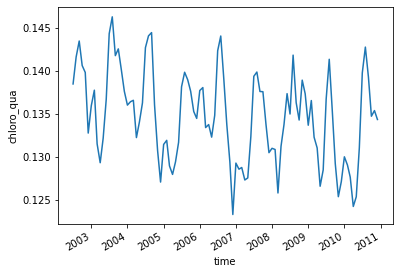

In [4]:
ds.chloro_qua.plot()